# Feature engeneering (FE)

In [1]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt 
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
random.seed(123) 
np.random.seed(123) 

In [20]:
df=pd.read_csv("data/TrainData.csv",engine="python", sep=",") 

In [3]:
df.head(2)

,Transaction.Date,Transaction.Amount,Customer.Age,Account.Age.Days,Transaction.Hour,source,browser,sex,Payment.Method,Product.Category,Quantity,Device.Used,Address.Match,Is.Fraudulent
0,2024-03-06 20:45:56,61.82,43,258,20,Ads,FireFox,M,credit card,electronics,3,tablet,1,0
1,2015-03-21 14:36:45,48.00,18,12,14,Ads,Chrome,M,PayPal,home & garden,2,desktop,1,0


## SMOTE - eksperymenty


In [21]:
df.loc[df["Is.Fraudulent"]==1].shape[0]/df.shape[0]  # IsFraudulent ratio 

0.07200680272108843

In [31]:
# df.drop(columns=["Unnamed: 0"],inplace=True) 

df["Transaction.Date"] = pd.to_datetime(df["Transaction.Date"], format = "ISO8601")

df['Transaction.Date_Num'] = df['Transaction.Date'].dt.year + df['Transaction.Date'].dt.dayofyear/365

dfSamples=df.drop(columns=["Transaction.Date"],inplace=False).copy()


X = dfSamples.drop("Is.Fraudulent", axis=1)
y = dfSamples["Is.Fraudulent"]


Numeric=['Transaction.Date_Num','Transaction.Amount',"Customer.Age",'Account.Age.Days','Transaction.Hour','Quantity'] 
Categorical = [i for i in X.columns if i not in Numeric]

In [32]:
scaler = StandardScaler()
X[Numeric] = scaler.fit_transform(X[Numeric])


In [33]:
X = pd.get_dummies(X, columns=Categorical, drop_first=True)

In [34]:
X

,Transaction.Amount,Customer.Age,Account.Age.Days,Transaction.Hour,Quantity,Transaction.Date_Num,source_Direct,source_SEO,browser_FireFox,browser_IE,...,Payment.Method_bank transfer,Payment.Method_credit card,Payment.Method_debit card,Product.Category_electronics,Product.Category_health & beauty,Product.Category_home & garden,Product.Category_toys & games,Device.Used_mobile,Device.Used_tablet,Address.Match_1
0,-0.328311,0.974597,1.391450,1.234657,-0.003593,1.009688,False,False,True,False,...,False,True,False,True,False,False,False,False,True,True
1,-0.392467,-1.685614,-1.053281,0.370993,-0.708811,-1.055489,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
2,1.236994,-1.047163,1.033685,0.658881,-1.414029,1.012214,False,False,False,False,...,True,False,False,False,False,False,True,False,False,True
3,-0.313549,-0.621530,-1.023467,-0.924504,-0.003593,-1.007506,False,False,False,True,...,False,True,False,False,True,False,False,True,False,True
4,-0.494595,0.761780,-0.586198,-0.204783,1.406842,-1.060540,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146995,-0.545659,0.123330,-0.943963,-0.492672,1.406842,-0.990459,True,False,True,False,...,False,False,False,False,False,False,True,False,True,True
146996,-0.401751,-0.940755,-0.427191,0.083105,-0.708811,-0.991090,False,True,False,True,...,False,False,False,True,False,False,False,True,False,True
146997,-0.327476,0.016921,-0.536508,-1.644224,0.701624,-0.981620,False,False,False,False,...,False,False,True,False,True,False,False,True,False,True
146998,0.421637,1.187414,-0.496757,1.090713,-0.708811,0.984434,False,False,False,True,...,True,False,False,False,False,False,True,True,False,True


In [35]:
smote = SMOTE(sampling_strategy=0.11, random_state=42,k_neighbors=5)
X,y=smote.fit_resample(X,y)

In [36]:
merged = pd.concat([X, y], axis=1, ignore_index=True)

#merged.to_csv("trainDataSMOTE.csv")

In [37]:
merged.loc[merged[23]==1].shape[0]/merged.shape[0]  # IsFraudulent ratio after SMOTE

0.0990952318055739

Wzrost o 2 punkty procentowe

---
# WALIDACJA

Zastosowanie SMOTE było konieczne z racji tego że faktycznych przypadków is.Fraudulent jest około 10 procent. Jednak przykładów powinno zostać dodanych trochę więcej niż 45 procent ponieważ dane są mocno niezbalansowane.

**Odpowiedź zespołu**: Ostatecznie zrezygnowaliśmy z technik augmentacji danych, między innymi ze względu na specyfikę branży, której dotyczą dane, oraz budzące obawy wady technik augmentacji, takie jak zaburzanie reprezentatywności próbki danych

## Zmienne czasowe

Utworzenie zmiennych reprezentujących miesiąc oraz dzień miesiąca

Text(0.5, 1.0, 'Frauds by day of month')

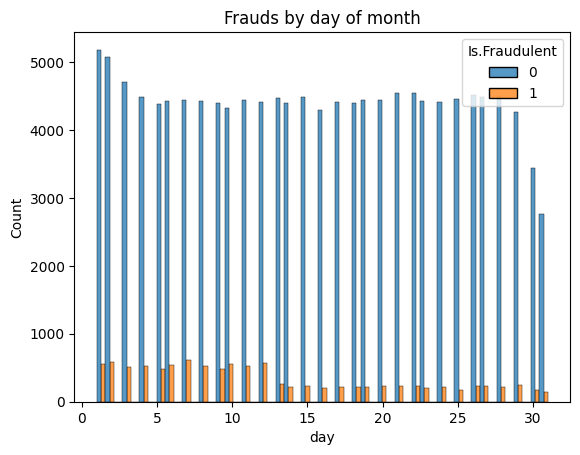

In [12]:
df["month"]=df["Transaction.Date"].dt.month
df["day"]=df["Transaction.Date"].dt.day
sns.histplot(df, x="day", hue="Is.Fraudulent", multiple="dodge") #seems in first part of months there are more frauds
plt.title("Frauds by day of month")

Binarny podział transakcji ze względu na część miesiąca, w której została dokonana

In [13]:
# splitting days of month for two categories
maximalSplit=0
output=0
for i in range(1,31):
    df["partOfMonth"]=df["day"].apply(lambda x: "First" if x<=i else "Second") 
    temp1=df.loc[(df["partOfMonth"]=="First") & df["Is.Fraudulent"]==1].shape[0]/df.loc[(df["partOfMonth"]=="First")].shape[0] #fraud rate
    if temp1>maximalSplit: 
        maximalSplit=temp1 
        output=i
print(output,maximalSplit) # thus 12 best split

12 0.1056458861018057


In [14]:
df["partOfMonth"]=df["day"].apply(lambda x: "First" if x<=12 else "Second")

Więcej oszustw w pierwszej części miesiąca, tj. w dniach 1-12

<Axes: xlabel='partOfMonth', ylabel='Count'>

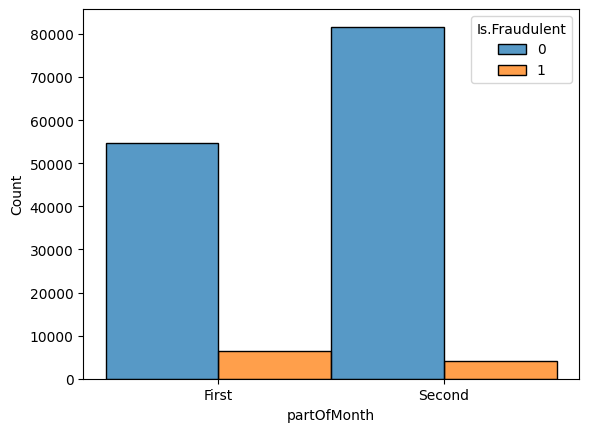

In [15]:
sns.histplot(data=df,x="partOfMonth",hue="Is.Fraudulent",multiple="dodge" ) 

Utworzenie okresowości miesięcy oraz godzin transakcji

In [16]:
# Convert Month to Sinusoidal Representation
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Convert Hour to Sinusoidal Representation
df["hour_sin"] = np.sin(2 * np.pi * df["Transaction.Hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["Transaction.Hour"] / 24)

df["hour_angle"] = np.arctan2(df["hour_sin"], df["hour_cos"])
df["month_angle"]=np.arctan2(df["month_sin"],df["month_cos"]) 

Nie widać nic ciekawego

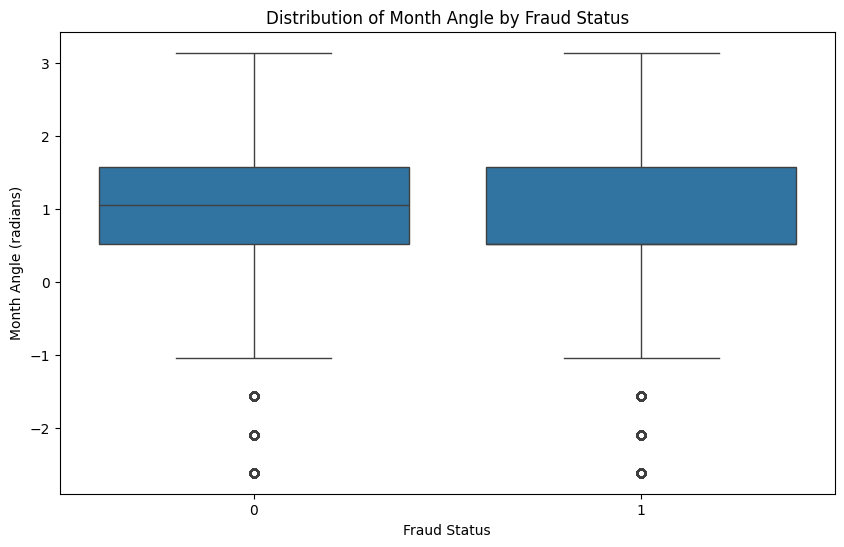

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Is.Fraudulent', y='month_angle')
plt.title('Distribution of Month Angle by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Month Angle (radians)')
plt.show()

In [18]:
df.loc[:,["month", "month_angle"]].drop_duplicates().sort_values(by="month").round(2) # which angle stands for which month

,month,month_angle
12,1,0.52
5,2,1.05
0,3,1.57
6,4,2.09
23,5,2.62
3,6,3.14
36,7,-2.62
11,8,-2.09
13,9,-1.57
46,10,-1.05


Nie widać nic ciekawego

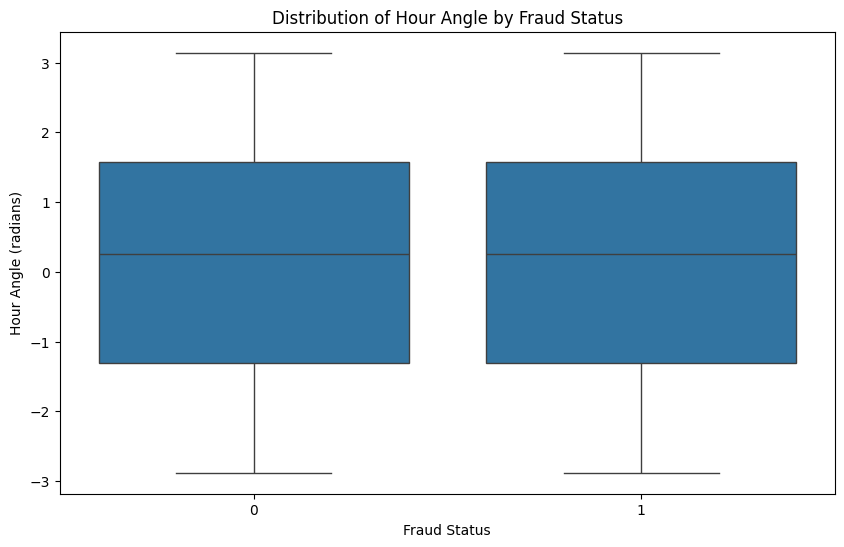

In [19]:
df.loc[:,["Transaction.Hour", "hour_angle"]].drop_duplicates().sort_values(by="Transaction.Hour").round(2)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Is.Fraudulent', y='hour_angle')
plt.title('Distribution of Hour Angle by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Hour Angle (radians)')
plt.show()

In [20]:
 # which angle stands for which hour
df.loc[:,["Transaction.Hour", "hour_angle"]].drop_duplicates().sort_values(by="Transaction.Hour").reset_index(drop=True).round(2)

,Transaction.Hour,hour_angle
0,0,0.00
1,1,0.26
2,2,0.52
3,3,0.79
4,4,1.05
5,5,1.31
6,6,1.57
7,7,1.83
8,8,2.09
9,9,2.36


# Utworzenie nowych cech:
* czy osoby przypisane do konta dokonującego transkacji są młode lub są seniorami,
* indykator transkacji opiewających na najwyższe kwoty,
* dzień tygodnia

## Nieletni

raczej nic ciekawego

In [21]:
df["Is.Minor"]=df["Customer.Age"].apply(lambda x : True if x<18 else False) 
print("percentage of minors:", sum(df["Is.Minor"])/df.shape[0] * 100)

print("percentage of frauds in minors:", df.loc[(df["Is.Minor"] == 1) & (df["Is.Fraudulent"] == 1)].shape[0]/df.loc[df["Is.Minor"]==1].shape[0]*100)

percentage of minors: 2.2829931972789113
percentage of frauds in minors: 5.214541120381407


## Seniorzy

In [39]:
df["Is.Senior"]=df["Customer.Age"].apply(lambda x : True if x>60 else False) 
print("percentage of seniors:", sum(df["Is.Senior"])/df.shape[0] * 100)

print("percentage of frauds in seniors:", df.loc[(df["Is.Senior"] == 1) & (df["Is.Fraudulent"] == 1)].shape[0]/df.loc[df["Is.Senior"]==1].shape[0]*100)

percentage of seniors: 0.33129251700680273
percentage of frauds in seniors: 6.7761806981519515


raczej nic ciekawego

<Axes: xlabel='Is.Fraudulent', ylabel='Is.Senior'>

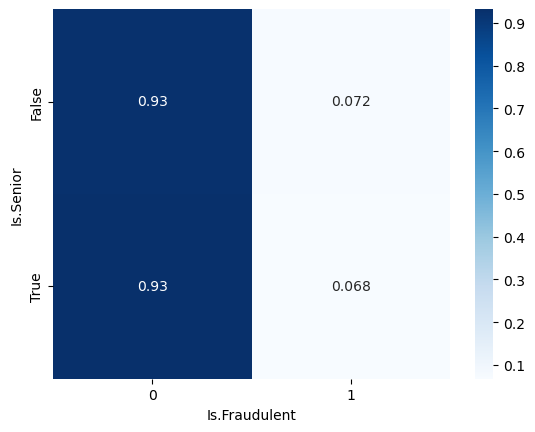

In [50]:
cross = pd.crosstab(df["Is.Senior"], df["Is.Fraudulent"], normalize="index")
sns.heatmap(cross, annot = True, cmap="Blues")

## Wysokie kwoty transakcji

nic ciekawego

In [26]:
#NOTHING FANCY
HighAmountInt=df["Transaction.Amount"].quantile(0.95)
df["Is.HighAmount"]=df["Transaction.Amount"].apply(lambda x : True if x>=HighAmountInt else False) 

print("Is.HighAmount", sum(df["Is.HighAmount"])/df.shape[0] * 100)

print("percentage of frauds high amount:", df.loc[(df["Is.HighAmount"] == 1) & (df["Is.Fraudulent"] == 1)].shape[0]/df.loc[df["Is.HighAmount"]==1].shape[0]*100)


# FRAUDS RATHER NOT IN HIGH AMOUNTS

Is.HighAmount 5.0
percentage of frauds high amount: 15.496598639455783


## Dzień tygodnia

<Axes: xlabel='Transaction.Weekday', ylabel='Count'>

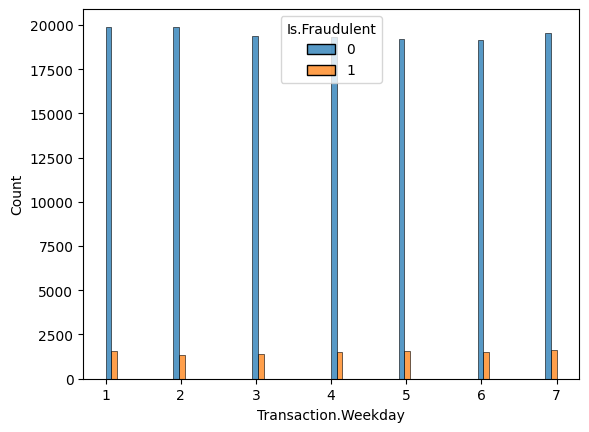

In [24]:
# DAY OF THE WEEK 
  # Ensure it's in datetime format
df["Transaction.Weekday"] = df["Transaction.Date"].dt.weekday + 1  # 1 = Monday, 7 = Sunday
sns.histplot(data=df,x="Transaction.Weekday",hue="Is.Fraudulent",multiple="dodge") 

nic ciekawego

In [25]:
#PERHAPS?
for i in range(1, 8): 
    fraud_count = df.loc[(df["Transaction.Weekday"] == i) & (df["Is.Fraudulent"] == 1)].shape[0]
    total_count = df.loc[df["Transaction.Weekday"] == i].shape[0]
    fraud_rate = fraud_count / total_count if total_count > 0 else 0  
    print(f"{i}-th day: {fraud_rate:.4f} fraud rate")

1-th day: 0.0738 fraud rate
2-th day: 0.0634 fraud rate
3-th day: 0.0662 fraud rate
4-th day: 0.0737 fraud rate
5-th day: 0.0764 fraud rate
6-th day: 0.0741 fraud rate
7-th day: 0.0765 fraud rate


In [33]:
df["source"].value_counts() 

source
SEO       58886
Ads       58380
Direct    29734
Name: count, dtype: int64

nic ciekawego

<Axes: xlabel='Payment.Method', ylabel='Count'>

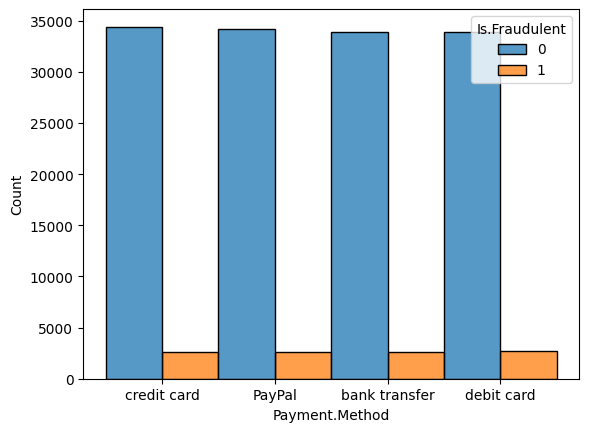

In [42]:
sns.histplot(data=df,x="Payment.Method",hue="Is.Fraudulent",multiple="dodge") 

In [51]:
temp = df.groupby("Is.Fraudulent")["Payment.Method"].value_counts() 

In [52]:
temp 

Is.Fraudulent  Payment.Method
0              credit card       34416
               PayPal            34239
               debit card        33904
               bank transfer     33856
1              debit card         2691
               bank transfer      2634
               credit card        2632
               PayPal             2628
Name: count, dtype: int64

## Wnioski
Jedyna odkryta zauważalna zależność to zwiększona liczba oszustw w pierwszych 12 dniach miesiąca w porównaniu do jego pozostałej części

---
# WALIDACJA
Można dodać więcej cech czasowych, np. czy transakcja odbywa się w weekend. Struktura zbiorów (treningowy, walidacyjny, testowy) jest dobrze zrobiona. Więcej komentarzy byłoby bardzo mile widziane.